<a href="https://colab.research.google.com/github/james-yu2005/pytorch-practice/blob/main/pytorch_workflow_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Pytorch workflow
1. prepare data,
2. build model,
3. fit model to data (train),
4. make predictions and evaluate those predictions,
5. save and load model,
6. put all together

In [2]:
import torch
from torch import nn
import matplotlib.pyplot as plt
## nn contains all of pytorch building blocks for neural networks

torch.__version__

'2.8.0+cu126'

In [5]:
# Data preparation and loading --> data is legit anything bro
# Make a straight line with known parameters

w = 0.7
b = 0.3

start = 0
end = 1
step = 0.02
X = torch.arange(start,end,step).unsqueeze(dim=1) # add extra dimension at index 1
y = w * X + b
X[:20], y[:20], len(X), len(y), X.shape, y.shape

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800],
         [0.2000],
         [0.2200],
         [0.2400],
         [0.2600],
         [0.2800],
         [0.3000],
         [0.3200],
         [0.3400],
         [0.3600],
         [0.3800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260],
         [0.4400],
         [0.4540],
         [0.4680],
         [0.4820],
         [0.4960],
         [0.5100],
         [0.5240],
         [0.5380],
         [0.5520],
         [0.5660]]),
 50,
 50,
 torch.Size([50, 1]),
 torch.Size([50, 1]))

In [9]:
# Create a train/test split
train_split = int(0.8 * len(X))
X_train,y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]
len(X_test), len(X_train)

(10, 40)

In [17]:
def plot_predictions(train_data=X_train,
                     train_labels=y_train,
                     test_data=X_test,
                     test_labels=y_test,
                     predictions=None):
  # Plot training data in blue
  plt.scatter(train_data, train_labels, c='b', s=4, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c='r', s=4, label="Testing data")

  if predictions:
    plt.scatter(test_data, predictions, c='g', s=4, label="Predictions")

  plt.legend(prop={"size": 14})
  plt.plot()

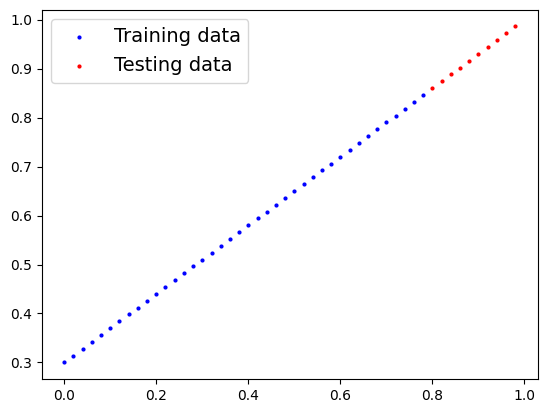

In [18]:
plot_predictions()

## Build Model

Use gradient descent and backpropagation

In [ ]:
# Linear regression model class
class Model(nn.module): # almost everything in pytorch inherits from nn.module
  def __init__(self):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(1, requires_grad=True, dtype=torch.float32))
    self.bias = nn.Parameter(torch.randn(1, requires_grade=True, dtype=torch.float32))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.weights * x + self.bias
